In [27]:
import time
import requests
import logging
import json
import pandas as pd
from urllib.parse import urlencode
import matplotlib.pyplot as plt
from typing import Dict, Any, Optional, List

In [42]:
api_url = "https://archive-api.open-meteo.com/v1/archive?"
response = requests.get(api_url)
response.status_code


200

In [116]:
logger = logging.getLogger(__name__)

# We use capital letters for global constants

API_URL = "https://archive-api.open-meteo.com/v1/archive?"

COORDINATES = {
    "Madrid": {"latitude": 40.416775, "longitude": -3.703790},
    "London": {"latitude": 51.507351, "longitude": -0.127758},
    "Rio": {"latitude": -22.906847, "longitude": -43.172896},
}

VARIABLES = ["temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max"]



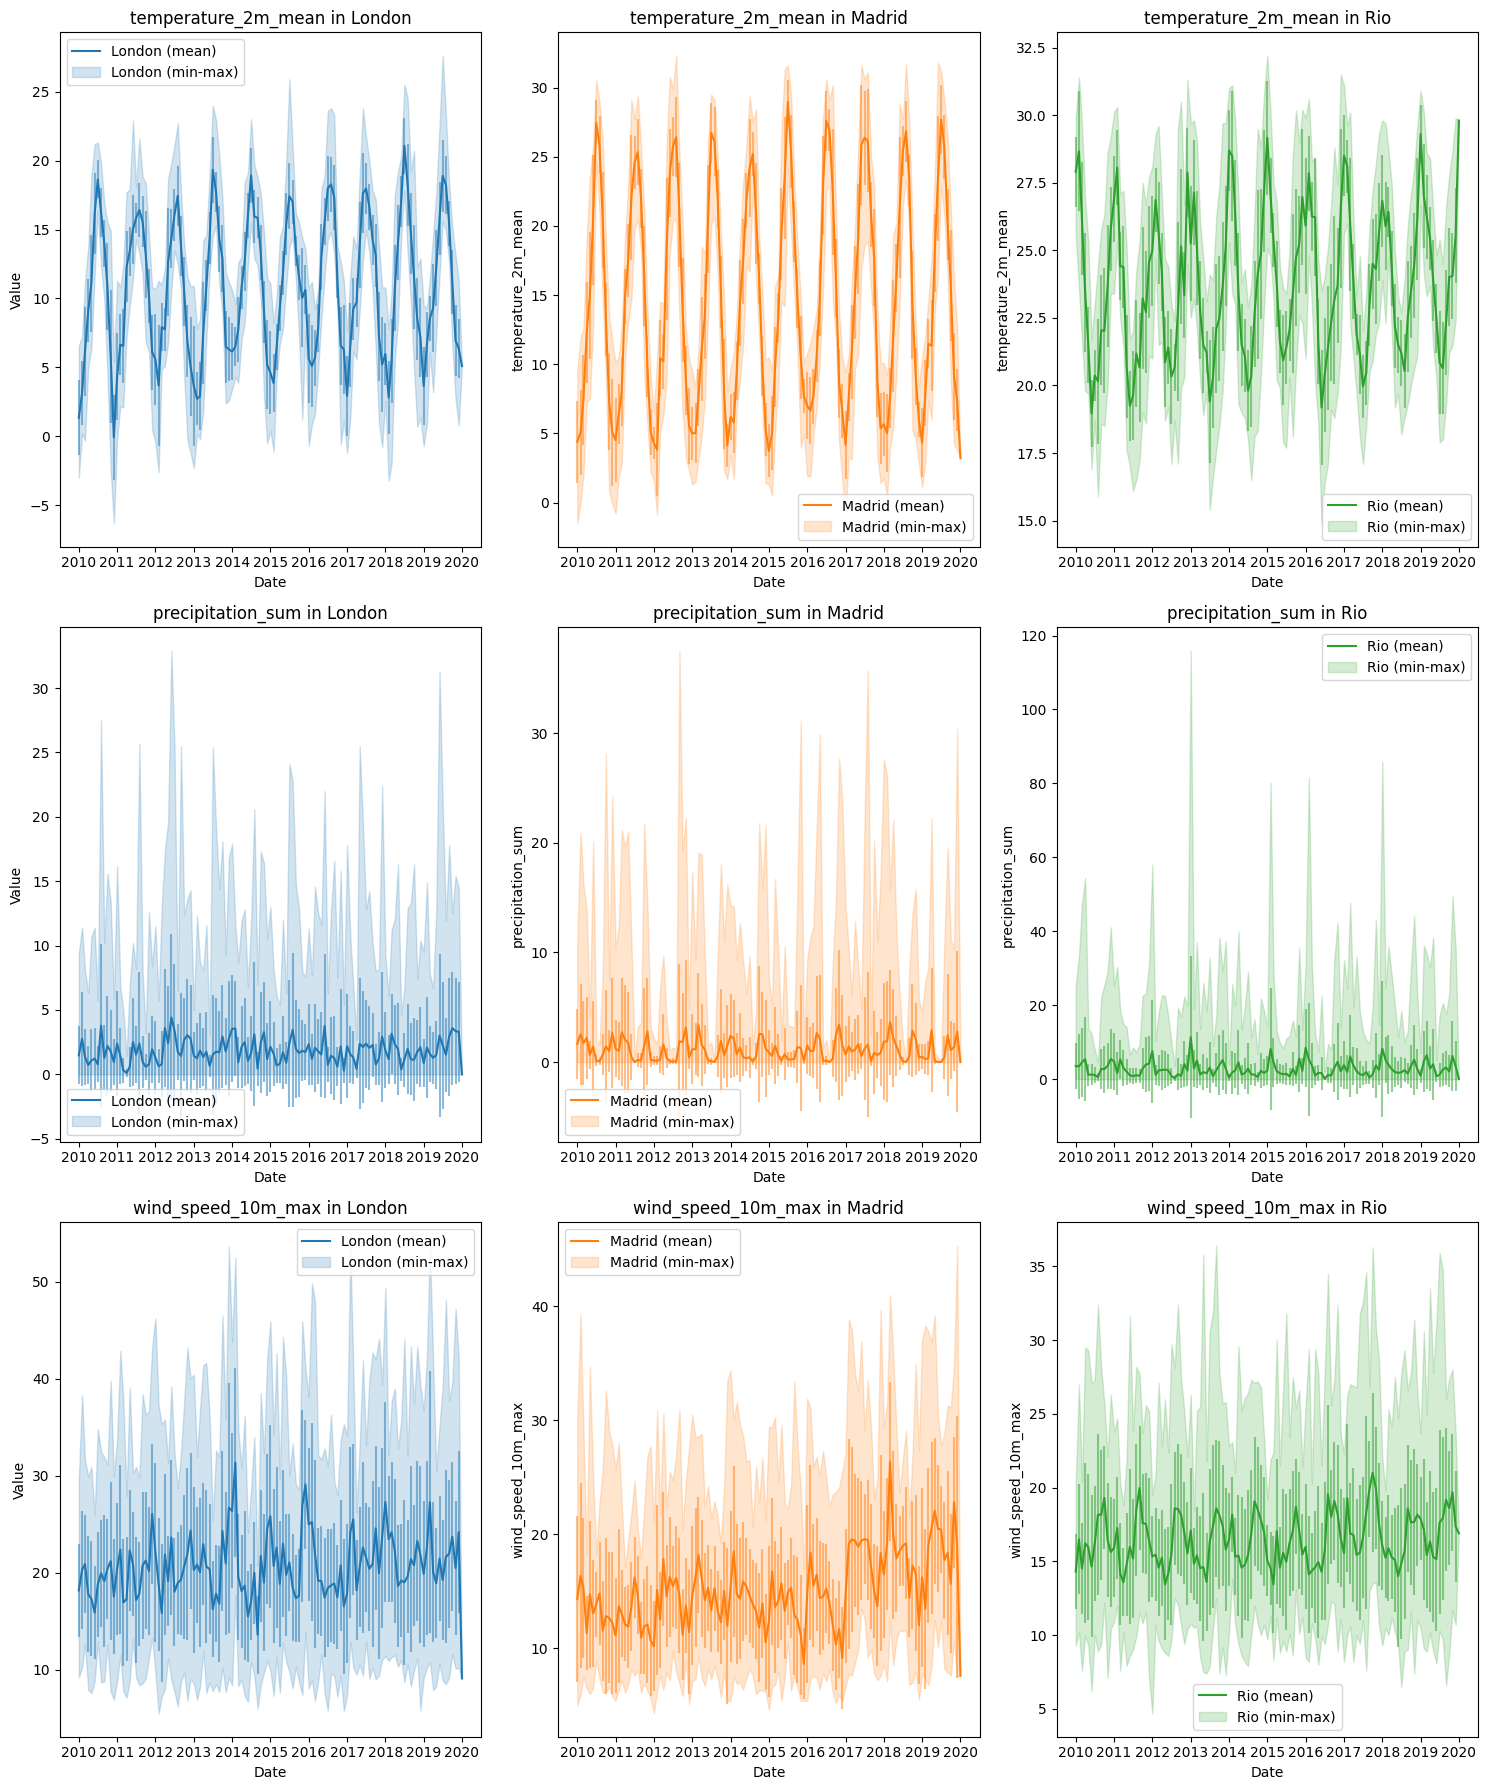

In [386]:
def get_data_meteo_api(
        longitude: float, latitude: float, start_date: str, end_date: str,
):
    headers = {} 

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ",".join(VARIABLES)
    }

    return request_with_cooloff(API_URL + urlencode(params, safe=","), headers) # Translates a string into a valid URL

# With urlencode, we get something like https://api.open-meteo.com/v1/forecast?latitude=40.4&longitude=-3.7&start_date=2025-10-01&...

def _request_with_cooloff( # It starts with _ to indicate that it's a private function
        url: str,
        headers: Dict[str,any],
        num_attempts: int,
        payload: Optional[Dict[str, any]] = None, # Es opcional, si no se pasa es None
) -> requests.Response:
    """
    Call url using requests- If endpount returns error wait a cooloff period and try again, doubling
    the cooloff period each time upm to num_attemps.
    """
    cooloff = 1
    for call_count in range(num_attempts):
        try:
            if payload is None:
                response = requests.get(url, headers=headers)
                response.json = "json_dummy"
                response.status_code = 200
            else:
                response = requests.post(url,headers=headers, json=payload) # En este caso, creo que no es necesatio el POST
            response.raise_for_status()  # Raise an error for bad status codes

        # If there's a connection error, we log it and retry after a cooloff period (exponential backoff)
        except requests.exceptions.ConnectionError as e:
            print("Error de conexión")
            logger.info("API refused the connection")
            logger.warning(e)
            if call_count != (num_attempts - 1):
                time.sleep(cooloff)
                cooloff *= 2
                continue # Continúa con el bucle hasta que se cumpla la condición, y en ese caso, hace "raise" del error
            else:
                raise
        
        # HTTP error occurred
        except requests.exceptions.HTTPError as e:
            logger.warning(e)
            if response.status_code == 404: # Error 404: Not Found, it doesn't make sense to retry
                raise

            # For other HTTP errors, we log the status code and retry after a cooloff period
            logger.info(f"API return code {response.status_code} cooloff at {cooloff}")
            if call_count != (num_attempts - 1):
                time.sleep(cooloff)
                cooloff *= 2
                continue
            else:
                raise
        # In case there's no error, we return the response
        return response
    

def request_with_cooloff(
        url: str,
        headers: Dict[str,any],
        payload: Optional[Dict[str, any]] = None,
        num_attempts: int = 10,
) -> Dict[Any, Any]:
    return json.loads(
        _request_with_cooloff(
            url, 
            headers,
            num_attempts,
            payload
        ).content.decode("utf-8") # requests.Response object is in bytes, so we decode it to string by doing .decode("utf-8") 
    ) 

def compute_monthly_statistics(
        data: pd.DataFrame, meteo_variables: List[str]
) -> pd.DataFrame:
    """
    Compute monthly statistics (mean, max, min) for the given meteorological variables.
    
    """

    data["time"] = pd.to_datetime(data["time"])
    
    grouped = data.groupby([data["city"], data["time"].dt.to_period("M")]) # .groupby returns an iterable of (group_name, group_dataframe) tuples
                                                                           # dt. is used to access datetime properties of the Series values, and to_period("M") converts to monthly periods
                                                                           
    results = []

    for (city, month), group in grouped: # city and month are the categories, group is the dataframe
        monthly_stats = {"city": city, "month": month.to_timestamp()} # We now convert back to timestamp because we want to plot it later

        for var in meteo_variables:
            monthly_stats[f"{var}_mean"] = group[var].mean()
            monthly_stats[f"{var}_max"] = group[var].max()
            monthly_stats[f"{var}_min"] = group[var].min()
            monthly_stats[f"{var}_std"] = group[var].std()

        results.append(monthly_stats)
        
    return pd.DataFrame(results)


def plot_timeseries(
        data: pd.DataFrame
        ):
    
    rows = len(VARIABLES)
    cols = len(data["city"].unique())
    fig, axs = plt.subplots(rows, cols, figsize=(15, 6*rows), squeeze=False)

    for i, variable in enumerate(VARIABLES):
        for k, city in enumerate(data["city"].unique()):
            city_data = data[data["city"] == city]

            axs[i,k].plot(
                city_data["month"], 
                city_data[f"{variable}_mean"],
                label=f"{city} (mean)",
                color=f"C{k}"
            )

            axs[i,k].fill_between(
                city_data["month"],
                city_data[f"{variable}_min"],
                city_data[f"{variable}_max"],
                color=f"C{k}",
                alpha=0.2,
                label=f"{city} (min-max)"
            )

            axs[i,k].errorbar(
                city_data["month"],
                city_data[f"{variable}_mean"],
                yerr=city_data[f"{variable}_std"],
                fmt="none",
                ecolor=f"C{k}",
                alpha=0.5,
            )

            axs[i,k].set_xlabel("Date")
            axs[i,k].set_ylabel(variable)
            if k == 0:
                axs[i,k].set_ylabel("Value")
            axs[i,k].set_title(f"{variable} in {city}")
            axs[i,k].legend()

    plt.tight_layout()
    plt.savefig(
        "climate_evolution.png", bbox_inches="tight"
    )


def main():
    data_list = []
    start_date = "2010-01-01"
    end_date = "2020-01-01"

    for city, coordinates in COORDINATES.items():
        lat = coordinates["latitude"]
        lon = coordinates["longitude"]

        data = pd.DataFrame(
            get_data_meteo_api(lon, lat, start_date, end_date)["daily"]
        ).assign(city=city)
        data_list.append(data)
    data = pd.concat(data_list)

    calculated_data = compute_monthly_statistics(data, VARIABLES)

    plot_timeseries(calculated_data)

if __name__ == "__main__":
    main()
    

In [208]:
# Lets call the function
city = "Madrid"
lat = COORDINATES[city]["latitude"]
lon = COORDINATES[city]["longitude"]
start_date = "2010-01-01"
end_date = "2020-01-01"

r = get_data_meteo_api(lon, lat, start_date, end_date)
r

{'latitude': 40.386642,
 'longitude': -3.6760864,
 'generationtime_ms': 970.6722497940063,
 'utc_offset_seconds': 0,
 'timezone': 'GMT',
 'timezone_abbreviation': 'GMT',
 'elevation': 666.0,
 'daily_units': {'time': 'iso8601',
  'temperature_2m_mean': '°C',
  'precipitation_sum': 'mm',
  'wind_speed_10m_max': 'km/h'},
 'daily': {'time': ['2010-01-01',
   '2010-01-02',
   '2010-01-03',
   '2010-01-04',
   '2010-01-05',
   '2010-01-06',
   '2010-01-07',
   '2010-01-08',
   '2010-01-09',
   '2010-01-10',
   '2010-01-11',
   '2010-01-12',
   '2010-01-13',
   '2010-01-14',
   '2010-01-15',
   '2010-01-16',
   '2010-01-17',
   '2010-01-18',
   '2010-01-19',
   '2010-01-20',
   '2010-01-21',
   '2010-01-22',
   '2010-01-23',
   '2010-01-24',
   '2010-01-25',
   '2010-01-26',
   '2010-01-27',
   '2010-01-28',
   '2010-01-29',
   '2010-01-30',
   '2010-01-31',
   '2010-02-01',
   '2010-02-02',
   '2010-02-03',
   '2010-02-04',
   '2010-02-05',
   '2010-02-06',
   '2010-02-07',
   '2010-02-08',


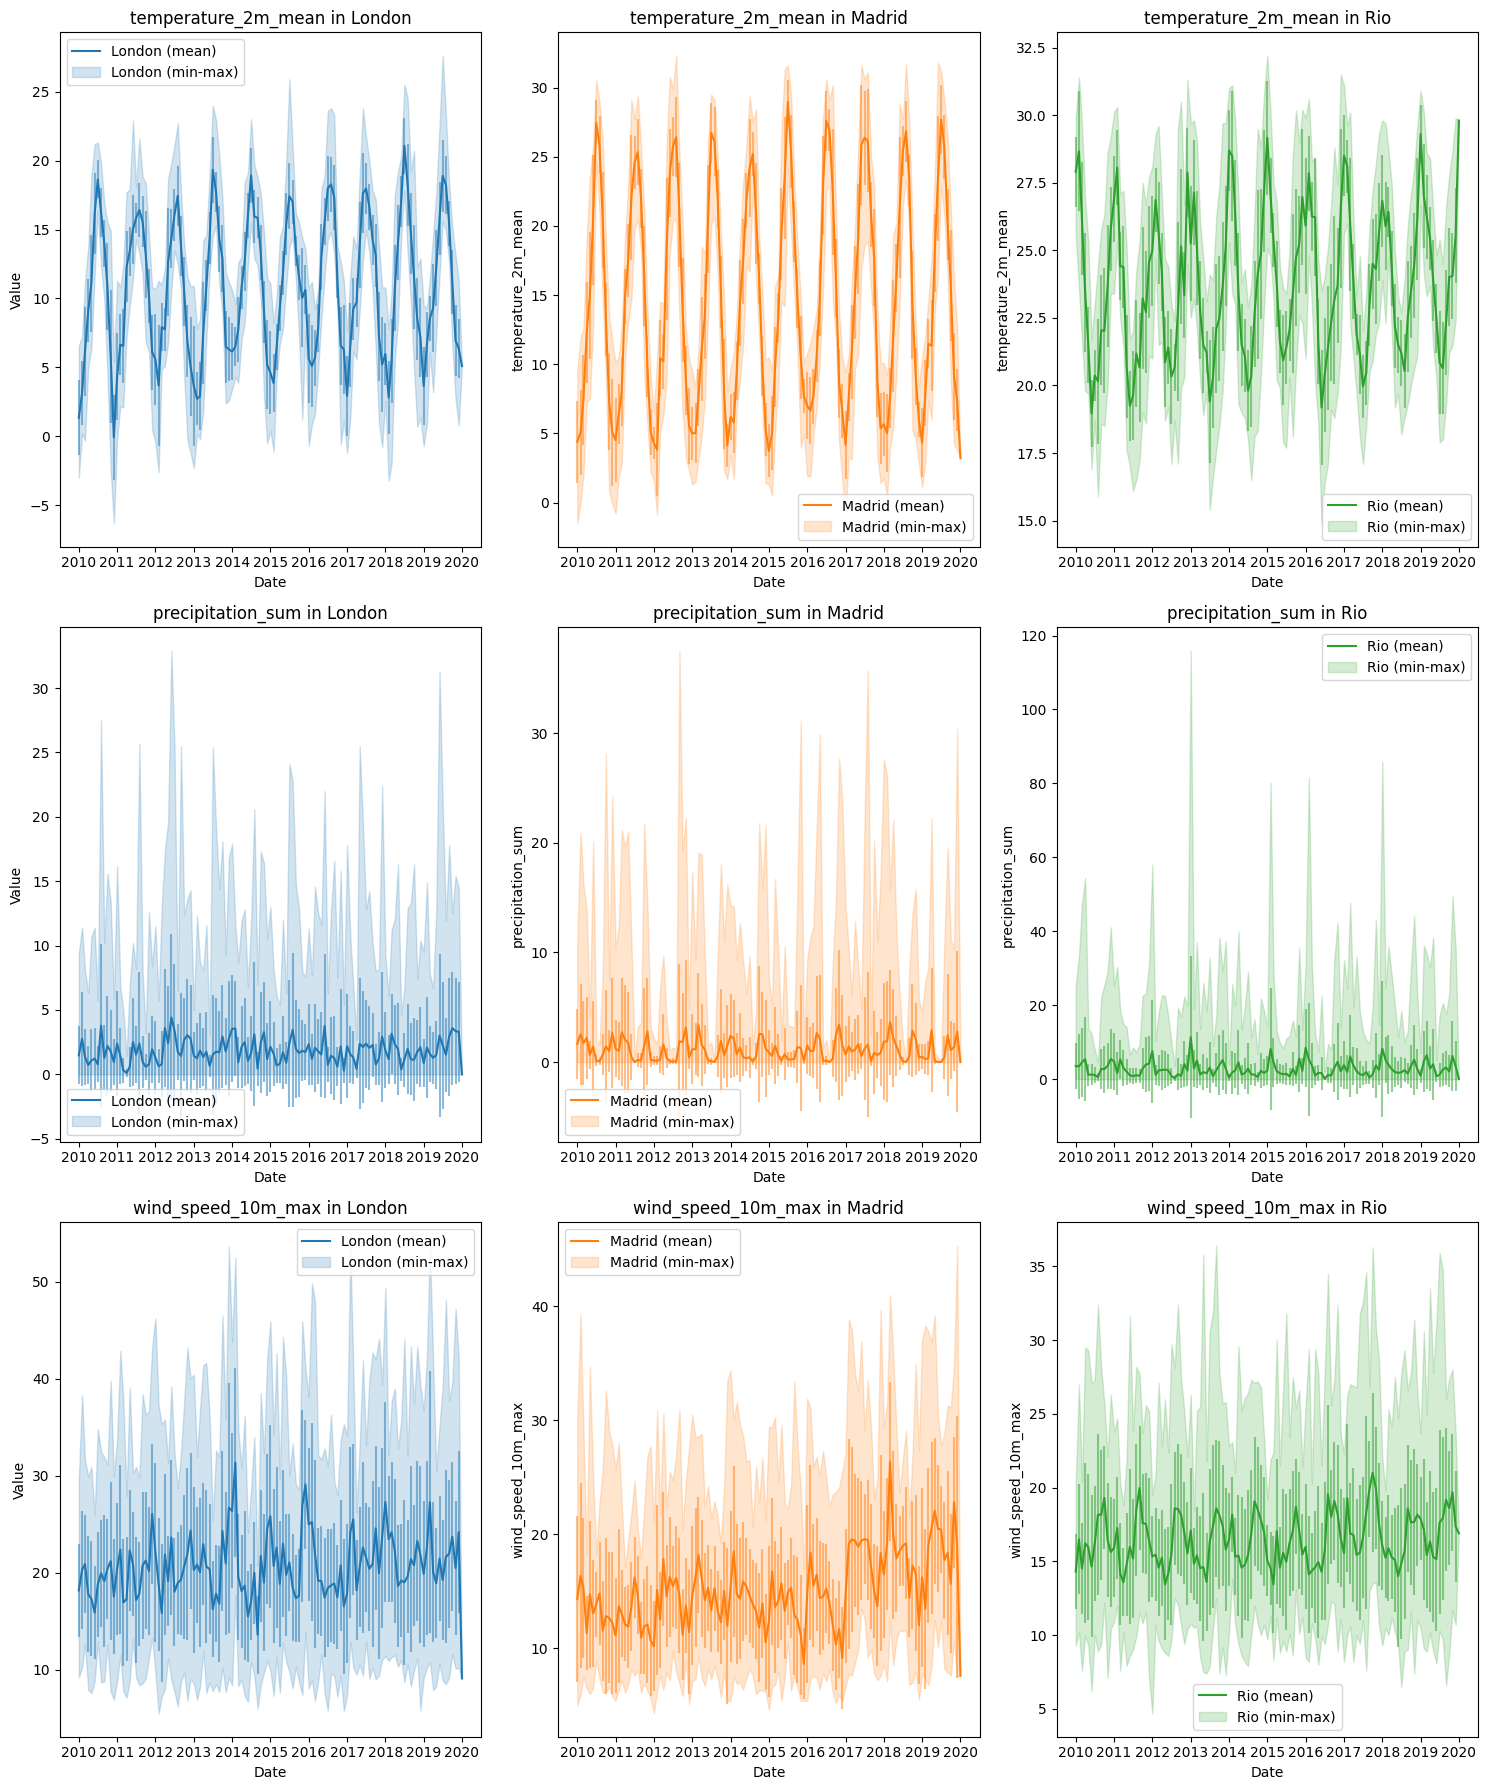

In [ ]:
def main